### This notebook produces figures from Ivankovic *et al.*

In [1]:
from inspect import isfunction, ismethod, isgeneratorfunction, isgenerator, isroutine
from inspect import isabstract, isclass, ismodule, istraceback, isframe, iscode, isbuiltin
from inspect import ismethoddescriptor, isdatadescriptor, isgetsetdescriptor, ismemberdescriptor
from inspect import isawaitable, iscoroutinefunction, iscoroutine

from collections.abc import Iterable as iterable

import pickle

def isfx(field): return ismethod(field) or isfunction(field)

class GhostSet:
    """ enhanced interface (ghost) to retrieve class fields """
    def _meta(data): return {k:v for k,v in data.__dict__.items() if not isfx(v)}
    def _at_last(_, sets): pass
    def _set(object, **sets):
        ''' use to fast initialize fields | needed to avoid initialization problems at copy by value '''
        for field in sets: setattr(object, field, sets[field])
        object._at_last(sets)
GSet = GhostSet

def meta(object):
    ''' retrieves clonable object metadata (__dict__) as a copy '''
    if isinstance(object, GSet): return object._meta()
    return {}

class ClonableObjectGhost:
    """ enhanced interface (ghost) for clonable objects """
    def _by_val(_, depth=-1, _layer=0): pass
GCo = ClonableObjectGhost

class ClonableObject(GSet, GCo):
    """ base clonable object """
    def __init__(this, **data): this._set(**data)
    def __call__(_, **options): _._set(**options)
    def _by_val(_, depth=-1, _layer=0):
        copy = type(_)()
        copy._set(**_._meta())
        if depth<0 or depth>_layer:
            for field in copy.__dict__:
                if isinstance(copy.__dict__[field], ClonableObjectGhost):
                    copy.__dict__[field] = copy.__dict__[field]._by_val(depth,_layer+1)
        return copy
COb = ClonableObject

def copy_by_val(object, depth=-1, _layer=0):
    if isinstance(object, GCo): return object._by_val(depth,_layer)
    return object
copy = by_val = vof = copy_by_val

class ComparableGhost:
    """ enhanced interface (ghost) for comparing instances """
    def _compare(a, b):
        if type(a) != type(b): return False
        if a.__dict__ == b.__dict__: return True
        return False
    def __eq__(a, b): return a._compare(b)
GEq = ComparableGhost

class IterableObjectGhost(GSet):
    """ enhanced interface (ghost) for iterables: exposes __dict__,
        therefore Iterable Objects are like lua dictionaries """
    def __contains__(this, key): return key in this.__dict__
    def __iter__(this): return iter(this.__dict__)
    def items(my): return my.__dict__.items()
    def __getitem__(by, field): return by.__dict__[field]
    def __setitem__(by, field, value): by.__dict__[field] = value
    def pop(by, field): return by.__dict__.pop(field)
GIo = IterableObjectGhost

class ReprGhost:
    """ enhanced interface (ghost) for the skeleton method _repr,
        see implementation of Struct for a working example;
        Record __repr__ override uses _lines_ for max lines display """
    _lines_ = 31
    _chars_ = 13
    _msgsz_ = 62
    _ellipsis_ = ' ... '
    def _repr(my, value):
        _type = ''.join(''.join(str(type(value)).split('class ')).split("'"))
        _value = '{}'.format(value)
        if len(_value)>my._chars_:
            show = int(my._chars_/2)
            _value = _value[:show]+my._ellipsis_+_value[-show:]
        return '{} {}'.format(_type, _value)
    def _resize(this, message, at=.7):
        if len(message)>this._msgsz_:
            start = int(at*this._msgsz_)
            end = this._msgsz_-start
            return message[:start]+this._ellipsis_+message[-end:]
        return message
GRe = ReprGhost

def set_repr_to(lines): GRe._lines_ = lines

class Struct(COb, GEq, GIo, GRe):
    """ structured autoprintable object, behaves like a lua dictionary """
    def __repr__(_):
        return '\n'.join(['{}:\t{}'.format(k, _._repr(v)) for k,v in _.items()])
struct = Struct

class RecordableGhost:
    """ enhanced interface (ghost) for type recording,
        see Record for a working example """
    @staticmethod
    def load(filename):
        with open(filename, 'rb') as file: return pickle.load(file)
    def save(data, filename):
        with open(filename, 'wb') as file: pickle.dump(data, file)
        
GRec = RecordableGhost

class Record(GSet, GCo, GRec, GEq, GRe):
    """ wrapper for any object or value, auto-inspects and provides load/save type structure """
    data = None
    _check = dict(
            isfunction=isfunction, ismethod=ismethod, isgeneratorfunction=isgeneratorfunction, isgenerator=isgenerator, isroutine=isroutine,
            isabstract=isabstract, isclass=isclass, ismodule=ismodule, istraceback=istraceback, isframe=isframe, iscode=iscode, isbuiltin=isbuiltin,
            ismethoddescriptor=ismethoddescriptor, isdatadescriptor=isdatadescriptor, isgetsetdescriptor=isgetsetdescriptor, ismemberdescriptor=ismemberdescriptor,
            isawaitable=isawaitable, iscoroutinefunction=iscoroutinefunction, iscoroutine=iscoroutine
                   )
    def __init__(this, token, **meta):
        this.data = token
        this.__dict__.update({k:v(token) for k,v in this._check.items()})
        super()._set(**meta)
    @property
    def type(_): return type(_.data)
    def inherits(_, *types): return issubclass(_.type, types)
    @property
    def isbaseiterable(_): return _.inherits(tuple, list, dict, set) or _.isgenerator or _.isgeneratorfunction
    @property
    def isiterable(_): return isinstance(_.data, iterable) and _.type is not str
    def _clone_iterable(_):
        if _.inherits(dict): return _.data.copy()
        elif _.isgenerator or _.isgeneratorfunction: return (i for i in list(_.data))
        else: return type(_.data)(list(_.data)[:])
    def _meta(data): return {k:v for k,v in data.__dict__.items() if k != 'data' and not isfx(v)}
    def _by_val(_, depth=-1, layer=0):
        data = _.data
        if _.isiterable: data = _._clone_iterable()
        elif _.inherits(ClonableObjectGhost): data = by_val(data, depth, layer)
        return type(_)(data, **meta(_))
    def __enter__(self): self._instance = self; return self
    def __exit__(self, type, value, traceback): self._instance = None
    def __repr__(self):
        if not hasattr(self, '_preprint'): return Record(self.data, _preprint='', _lines=Record(Record._lines_)).__repr__()
        if self.isbaseiterable:
            pre, repr = self._preprint, ''
            for n,i in enumerate(self.data):
                if self._lines.data == 0: break
                else: self._lines.data -= 1
                index, item = str(n), i
                if self.inherits(dict): index += ' ({})'.format(str(i)); item = self.data[i]
                repr += pre+'{}: '.format(index)
                next = Record(item, _preprint=pre+'\t', _lines=self._lines)
                if next.isiterable: repr += '\n'
                repr += next.__repr__()
                repr += '\n'
            return repr
        elif self.inherits(GCo): return Record(self.data._meta(), _preprint=self._preprint, _lines=self._lines).__repr__()
        else: return self._repr(self.data)
REc = Record

class Bisect(list, COb):
    """ bisect implementation using clonable objects """
    def __init__(set, *items, key=None, reverse=False):
        if not key: key = lambda  x:x
        super().__init__(sorted(items, reverse=reverse, key=key))
    def _bisect(set, item, key, reverse, bottom, top):
        def _(check):
            if key: return key(check)
            return check
        at = int((top-bottom)/2)+bottom
        if len(set)==0: return (0,-1)
        if item==_(set[at]): return (at,0)
        bigger = item<_(set[at])
        if bigger != reverse:
            if at-bottom>0: return set._bisect(item, key, reverse, bottom, at)
            return (at,-1)
        elif top-at>1: return set._bisect(item, key, reverse, at, top)
        return (at,1)
    def search(_, item, key=None, reverse=False):
        if not key: key = lambda x:x
        return _._bisect(item, key, reverse, 0, len(_))
    def _by_val(_, depth=-1, _layer=0):
        copy = super()._by_val(depth, _layer)
        copy += _[:]
        return copy
BSx = Bisect

##### Below we define the validation function to score networks relative to the resection.

In [2]:
def network_validation_score(net, resection, all_nodes):
    
    not_resection = len(all_nodes)-len(resection)
    tp = len(list(set(net)&set(resection)))
    fp = len(net) - tp
    tn = not_resection - fp
    
    return (tp / len(resection)) * (tn / not_resection)


In [3]:
selected_subject = "ASJ"

In [4]:
import os
import openpyxl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
main_folder = "/media/kivi/ADATA HV100/epigame-folder/"
path_net = main_folder + "selected_network_maxminav/"

In [6]:
woi_code = {'2':"preseizure5", '3':"preseizure4", '4':"preseizure3", '5':"preseizure2", '6':"preseizure1", '7':"transition1", '8':"transition2", '9':"transition60"}
woi_code_inverted = {y:x for x,y in woi_code.items()}

In [7]:
all_nodes = ['P1-P2', 'P4-P5', 'P8-P9', 'P9-P10', 'P10-P11', 'G1-G2', 'G8-G9', 'G9-G10', 'G10-G11', 'G11-G12', 'M1-M2', 'M8-M9', 'M9-M10', 'M10-M11', 'M11-M12', 'O1-O2', 'O2-O3', 'O5-O6', 'O6-O7', 'F1-F2', 'F7-F8', 'F8-F9', 'F9-F10', 'F10-F11', 'F11-F12', 'F12-F13', 'A1-A2', 'A2-A3', 'A3-A4', 'A7-A8', 'A8-A9', 'A9-A10', 'A10-A11', 'B1-B2', 'B2-B3', 'B5-B6', 'B6-B7', 'B7-B8', 'B8-B9', 'C1-C2', 'C5-C6', 'C6-C7', 'C7-C8', 'C8-C9', 'C9-C10', 'Q1-Q2', 'Q2-Q3', 'Q3-Q4', 'Q4-Q5', 'Q8-Q9', 'Q9-Q10', 'Q10-Q11', 'Q11-Q12', 'T1-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7', 'T7-T8', 'T8-T9', 'T9-T10', 'T10-T11', 'T11-T12', 'D1-D2', 'D2-D3', 'D3-D4', 'D4-D5', 'D5-D6', 'D6-D7', 'D7-D8', 'E1-E2', 'E2-E3', 'E3-E4', 'E4-E5', 'E5-E6', 'E6-E7', 'E7-E8', 'E8-E9', 'E9-E10', 'E10-E11', 'L1-L2', 'L2-L3', 'L5-L6', 'L6-L7', 'L7-L8', 'U1-U2', 'U2-U3', 'U3-U4', 'U4-U5', 'U5-U6', 'U6-U7', 'J1-J2', 'J10-J11', 'J11-J12', 'J12-J13', 'J13-J14', 'J14-J15']
resection = ['A3-A4', 'B2-B3', 'B5-B6', 'B6-B7', 'D3-D4', 'D4-D5', 'T1-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7', 'T7-T8', 'T8-T9', 'T9-T10', 'T10-T11', 'T11-T12']

In [8]:
df_rows = []

for file_net in os.listdir(path_net):

  filename = file_net.split("/")[-1].split(".")[0]

  subject_id = filename[0:3]

  if subject_id == selected_subject:
    # print("\nSelected network of", file_net)

    # Load attributes from filename "SUB-woi-connectivitymeasure-(fmin,fmax).res"
    woi = filename.split("-")[1]
    woi_id = woi_code_inverted[woi]
    conn_measure = filename.split("-")[2]

    # If the signal was not filtered in any specific frequency band, mark it as "NA"
    # If the signal was filtered, mark the frequency band minimum and maximum
    f_min = None if len(filename.split(".")[0].split("-")) == 3 else int(filename.split(".")[0].split("-")[3][1:-1].split(",")[0])
    f_max = None if len(filename.split(".")[0].split("-")) == 3 else int(filename.split(".")[0].split("-")[3][1:-1].split(",")[1])

    net = REc.load(path_net + file_net).data

    last_tested_n = list(net.test_nets.keys())[-1]
    # print(last_tested_n)
    # if last_tested_n>2: print(f"Evaluation score decreased at {last_tested_n} nodes:", net.test_nets[last_tested_n-1][0][-1], ">=", net.test_nets[last_tested_n][0][-1])

    eval_progression = [net.test_nets[n][0][-1] for n in net.test_nets.keys()]
    # print("Evaluation score progression:", eval_progression)
    eval_score = net.test_nets[last_tested_n-1][0][-1]

    selected = list(net.nodes)
    net_size = len(selected)
    best_pair = sorted(set([node for node in net.test_nets[2][0][1].split("<->")]))

    # print("\nOriginal resection:", resection)
    # print("Selected net:", selected)

    intersection = list(set(selected)&set(resection))
    # print("\nNet-Resection intersection:", intersection)
    S = network_validation_score(selected, resection, all_nodes)
    # print("Validation score =", val_score)

    df_rows.append([woi, woi_id, conn_measure, f_min, f_max, resection, 
                    best_pair, selected, net_size, 
                    intersection, eval_progression, eval_score, 
                    S])

  dataframe = pd.DataFrame(df_rows, columns=["WOI","WOI_ID","CM","F_MIN","F_MAX","RESECTION",
                                            "BEST_PAIR","NET","NET_SIZE",
                                            "INTERSECTION","EVAL_PROGRESSION","EVAL_SCORE",
                                            "VAL_SCORE"]) 

#### Add a sheet to an existing XLSX file, for the new subject.

In [ ]:
writer = pd.ExcelWriter(main_folder + "RESULTS_maxminav.xlsx", engine='openpyxl')

if os.path.exists(main_folder + "RESULTS_maxminav.xlsx"):
    book = openpyxl.load_workbook(main_folder + "RESULTS_maxminav.xlsx")
    writer.book = book

dataframe.sort_values("WOI").to_excel(writer, sheet_name=selected_subject)
writer.save()
writer.close()

Connectivity measures: {'PAC', 'SCI', 'PLI', 'PLV', 'CC', 'SCR'}


/tmp/ipykernel_41451/4281288889.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_val_score = df_val_score.pivot("F_MIN", "WOI_ID", "VAL_SCORE")


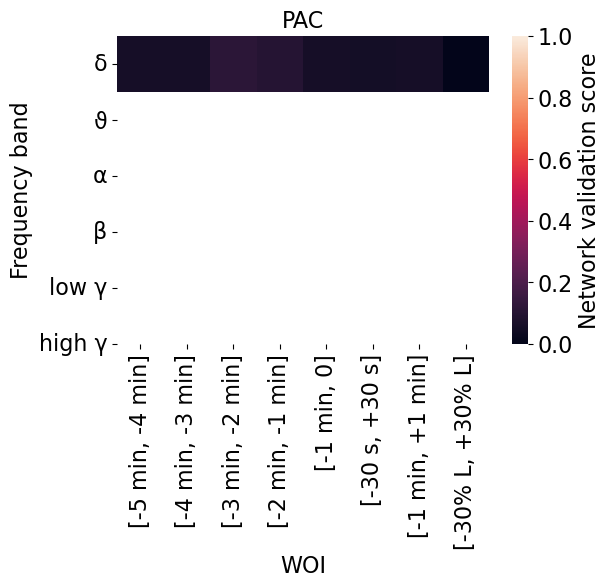

/tmp/ipykernel_41451/4281288889.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_val_score = df_val_score.pivot("F_MIN", "WOI_ID", "VAL_SCORE").sort_values("F_MIN")


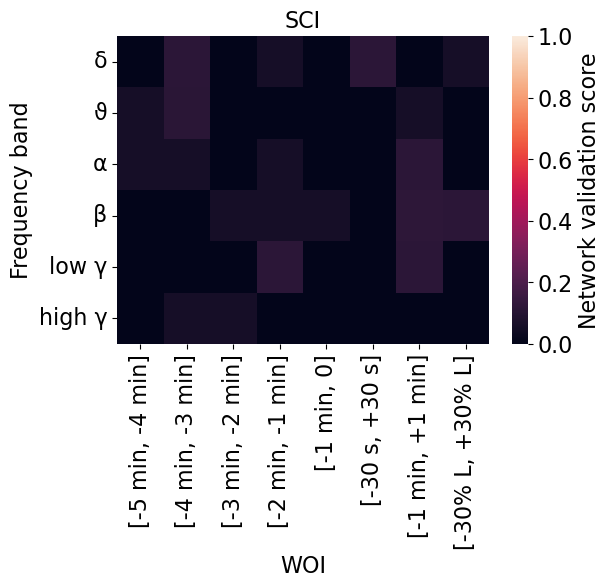

/tmp/ipykernel_41451/4281288889.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_val_score = df_val_score.pivot("F_MIN", "WOI_ID", "VAL_SCORE").sort_values("F_MIN")


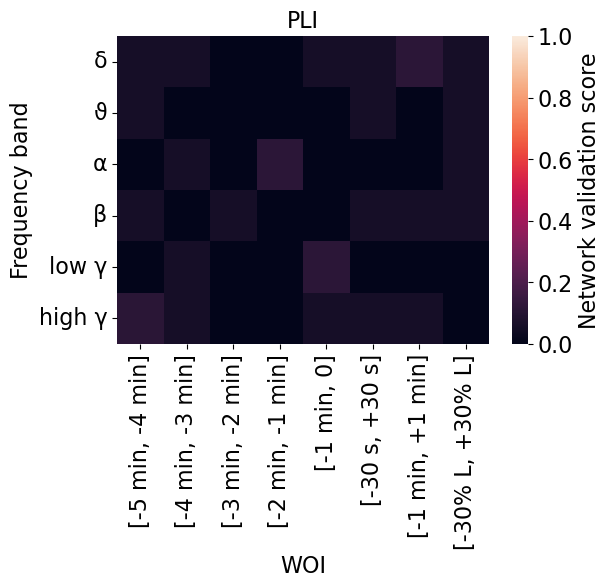

/tmp/ipykernel_41451/4281288889.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_val_score = df_val_score.pivot("F_MIN", "WOI_ID", "VAL_SCORE").sort_values("F_MIN")


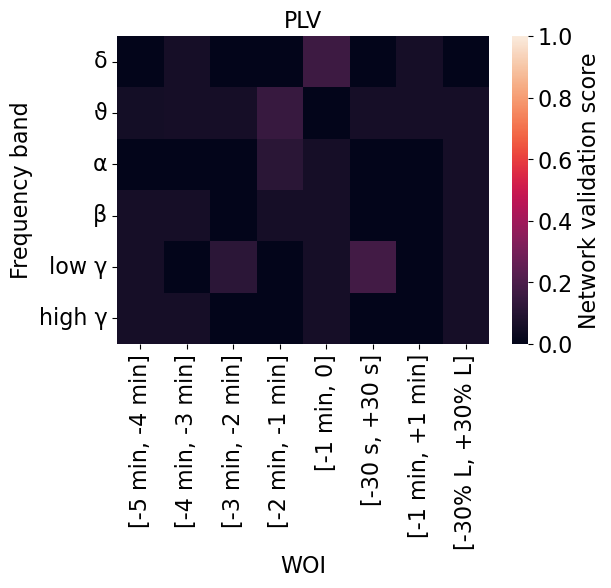

/tmp/ipykernel_41451/4281288889.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_val_score = df_val_score.pivot("F_MIN", "WOI_ID", "VAL_SCORE").sort_values("F_MIN")


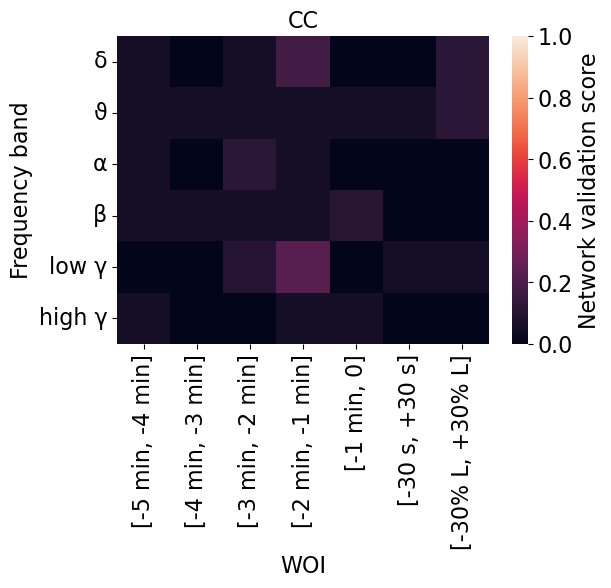

/tmp/ipykernel_41451/4281288889.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_val_score = df_val_score.pivot("F_MIN", "WOI_ID", "VAL_SCORE").sort_values("F_MIN")


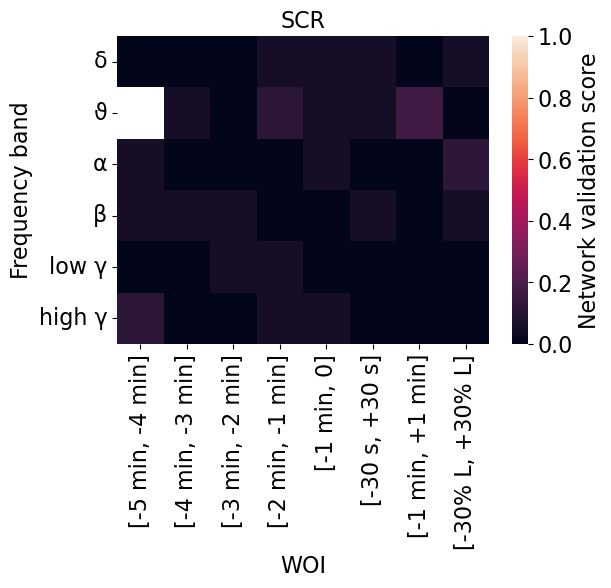

In [11]:
dataframe = pd.read_excel(main_folder + "RESULTS_maxminav.xlsx", sheet_name=selected_subject)

conn_measures = set(dataframe["CM"])
print("Connectivity measures:", conn_measures)

for cm in conn_measures:

    cm_dataframe = dataframe.groupby("CM").get_group(cm)

    df_val_score = cm_dataframe[["F_MIN", "F_MAX", "WOI", "WOI_ID", "VAL_SCORE"]]

    if cm not in ["PAC", "PEC"]:
        df_val_score = df_val_score.pivot("F_MIN", "WOI_ID", "VAL_SCORE").sort_values("F_MIN")
    else: 
        df_val_score = df_val_score.pivot("F_MIN", "WOI_ID", "VAL_SCORE")

    plt.figure(figsize=(6,4))
    ax = sns.heatmap(df_val_score, vmin=0, vmax=1, cbar_kws={"label": "Network validation score"})
    ax.figure.axes[-1].yaxis.label.set_size(16)
    ax.figure.axes[-1].tick_params(labelsize=16)
    plt.yticks(ticks=list(x+0.5 for x in range(6)), 
               labels=["δ", "ϑ", "α", "β", "low γ", "high γ"], 
               rotation=0, size=16)
    plt.ylabel("Frequency band", size=16)
    if cm=="CC": plt.xticks(ticks=list(x+0.5 for x in range(7)), 
                            labels=["[-5 min, -4 min]", "[-4 min, -3 min]", "[-3 min, -2 min]", "[-2 min, -1 min]", "[-1 min, 0]", "[-30 s, +30 s]", "[-30% L, +30% L]"], 
                            rotation=90, size=16)
    else: plt.xticks(ticks=list(x+0.5 for x in range(8)), 
                    labels=["[-5 min, -4 min]", "[-4 min, -3 min]", "[-3 min, -2 min]", "[-2 min, -1 min]", "[-1 min, 0]", "[-30 s, +30 s]", "[-1 min, +1 min]", "[-30% L, +30% L]"], 
                    rotation=90, size=16)
    plt.xlabel("WOI", size=16)
    plt.title(cm, size=16)
    plt.show()


In [12]:
selected_woi = "preseizure5"

best_combs = []

woi_nets, woi_cms = {},{}

woi_group = dataframe.groupby("WOI").get_group(selected_woi)
for idx_row,row in woi_group.iterrows():
    woi_nets[row[0]] = list(node[1:-1] for node in row[8][1:-1].split(", ")) # reformat string to list of nodes
    woi_cms[row[0]] = row[3]+"("+str(row[4]).split(".")[0]+","+str(row[5]).split(".")[0]+")-"

from itertools import combinations

n_max = 9
all_combs = {n:{} for n in range(2,n_max+1)}

N, Combination, Score = [],[],[]

for n in all_combs:
    combs = combinations(woi_nets.keys(), n)
    combs_val_scores = {}
    max_score, best_combs_n = 0,[]
    for comb in combs:
        agregate = []
        comb_label = ""
        for c in comb:
            agregate += woi_nets[c]
            comb_label += woi_cms[c]
        union = set(agregate)
        score = network_validation_score(union, resection, all_nodes)

        if score>max_score:
            max_score = score
            best_combs_n = [comb]
        elif score==max_score: best_combs_n.append(comb)

        N.append(n)
        Combination.append(comb_label[:-1])
        Score.append(score)

        combs_val_scores[comb_label[:-1]] = score
    
    best_combs+=best_combs_n

    print(f"\nNumber of combinations at {n} = {len(combs_val_scores)}")
    print(f"Best net by the combination {max(combs_val_scores, key=combs_val_scores.get)}")
    print(f"Score = {max(combs_val_scores.values())}")
    all_combs[n] = combs_val_scores


print("\nBest combinations:")
for n in all_combs:
    print(max(all_combs[n], key=all_combs[n].get))

dataframe_combs = pd.DataFrame({"N":N, "Combination":Combination, "Score":Score})


Number of combinations at 2 = 435
Best net by the combination SCR(70,150)-PLI(70,150)
Score = 0.21496005809731297

Number of combinations at 3 = 4060
Best net by the combination PLV(12,30)-SCR(70,150)-PLI(70,150)
Score = 0.26506899055918665

Number of combinations at 4 = 27405
Best net by the combination PLV(12,30)-SCR(70,150)-PLI(70,150)-PAC(nan,nan)
Score = 0.3137254901960784

Number of combinations at 5 = 142506
Best net by the combination PLV(12,30)-SCI(8,12)-SCR(70,150)-PLI(70,150)-PAC(nan,nan)
Score = 0.3558460421205519

Number of combinations at 6 = 593775
Best net by the combination PLV(12,30)-CC(70,150)-SCI(8,12)-SCR(70,150)-PLI(70,150)-PAC(nan,nan)
Score = 0.38925199709513436

Number of combinations at 7 = 2035800
Best net by the combination PLV(12,30)-CC(8,12)-CC(70,150)-SCI(8,12)-SCR(70,150)-PLI(0,4)-PAC(nan,nan)
Score = 0.41249092229484385

Number of combinations at 8 = 5852925
Best net by the combination PLV(12,30)-CC(8,12)-CC(70,150)-SCI(8,12)-SCR(70,150)-PLI(0,4)-PLI(4

<Axes: xlabel='N', ylabel='Score'>

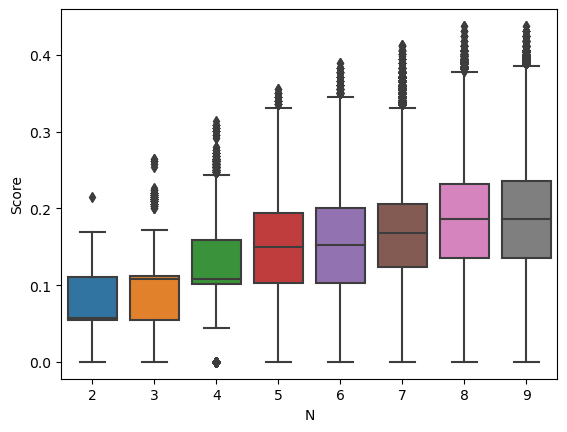

In [13]:
sns.boxplot(data=dataframe_combs, x="N", y="Score")

In [14]:
N, Best_comb, Best_score, Net_union, Net_size, TP, FP, TN = [],[],[],[],[],[],[],[] 

for comb in best_combs:
    n = 0
    agregate = []
    comb_label = ""
    for c in comb:
        n += 1
        agregate += woi_nets[c]
        comb_label += woi_cms[c]

    union = set(agregate)
    score = network_validation_score(union, resection, all_nodes)
    
    print(comb_label[:-1], score)
    print(sorted([n for n in union if n in resection]) + sorted([n for n in union if n not in resection]))
    print(len(union))
    
    not_resection = len(all_nodes)-len(resection)
    tp = len(list(set(union)&set(resection)))
    fp = len(union) - tp
    tn = not_resection - fp

    print("TP:", tp)
    print("FP:", fp)
    print("TN:", tn)

    N.append(n)
    Best_comb.append(comb_label[:-1])
    Best_score.append(score)
    Net_union.append(sorted([n for n in union if n in resection]) + sorted([n for n in union if n not in resection]))
    Net_size.append(len(union))
    TP.append(tp)
    FP.append(fp)
    TN.append(tn)

dataframe_best_combs = pd.DataFrame({"N":N, "BEST_COMB":Best_comb, "SCORE":Best_score, "NET_UNION":Net_union, "NET_SIZE":Net_size, "TP":TP, "FP":FP, "TN":TN})

SCR(70,150)-PLI(70,150) 0.21496005809731297
['D3-D4', 'D4-D5', 'T8-T9', 'T9-T10', 'C9-C10', 'D2-D3', 'M10-M11', 'O1-O2', 'Q1-Q2', 'Q11-Q12', 'U1-U2']
11
TP: 4
FP: 7
TN: 74
PLV(12,30)-SCR(70,150)-PLI(70,150) 0.26506899055918665
['D3-D4', 'D4-D5', 'T7-T8', 'T8-T9', 'T9-T10', 'C9-C10', 'D2-D3', 'E4-E5', 'M10-M11', 'O1-O2', 'Q1-Q2', 'Q11-Q12', 'U1-U2']
13
TP: 5
FP: 8
TN: 73
SCR(70,150)-PLI(70,150)-PAC(nan,nan) 0.26506899055918665
['B2-B3', 'D3-D4', 'D4-D5', 'T8-T9', 'T9-T10', 'C9-C10', 'D2-D3', 'M10-M11', 'O1-O2', 'Q1-Q2', 'Q11-Q12', 'U1-U2', 'U6-U7']
13
TP: 5
FP: 8
TN: 73
PLV(12,30)-SCR(70,150)-PLI(70,150)-PAC(nan,nan) 0.3137254901960784
['B2-B3', 'D3-D4', 'D4-D5', 'T7-T8', 'T8-T9', 'T9-T10', 'C9-C10', 'D2-D3', 'E4-E5', 'M10-M11', 'O1-O2', 'Q1-Q2', 'Q11-Q12', 'U1-U2', 'U6-U7']
15
TP: 6
FP: 9
TN: 72
PLV(12,30)-SCI(8,12)-SCR(70,150)-PLI(70,150)-PAC(nan,nan) 0.3558460421205519
['B2-B3', 'D3-D4', 'D4-D5', 'T3-T4', 'T7-T8', 'T8-T9', 'T9-T10', 'C9-C10', 'D2-D3', 'E4-E5', 'M10-M11', 'O1-O2', 'Q1

#### Add a sheet to an existing XLSX file, for the new WOI.

In [15]:
if os.path.exists(main_folder + f"{selected_subject}_BEST_COMB_RESULTS.xlsx"):
    book = openpyxl.load_workbook(main_folder + f"{selected_subject}_BEST_COMB_RESULTS.xlsx")
    writer.book = book

dataframe_best_combs.to_excel(writer, sheet_name=selected_woi)
writer.save()
writer.close()

NameError: name 'writer' is not defined

Check nets based on best combination.

In [17]:
for selected_woi in woi_code.values():

    print(f"\nWOI = {selected_woi}")

    dataframe = pd.read_excel(main_folder + "RESULTS_maxminav.xlsx", sheet_name=selected_subject)
    dataframe_best_combs = pd.read_excel(main_folder + f"{selected_subject}_BEST_COMB_RESULTS_maxminav.xlsx", sheet_name=selected_woi)

    top_methods = {}

    NETS = {}

    max_score = max(dataframe_best_combs["SCORE"])
    max_score_idx = [i for i in range(len(dataframe_best_combs["SCORE"])) if dataframe_best_combs["SCORE"][i] == max_score]

    print(f"Best score = {max_score}")
    print(f"Number of combinations = {len(max_score_idx)}")

    print("Combinations of:")
    for idx in max_score_idx:

        cms = dataframe_best_combs["BEST_COMB"][idx].split("-")
        print(len(cms))

        for cm in cms:

            top_methods[cm] = 1 if cm not in top_methods else top_methods[cm]+1

            acronym_len = len(cm.split("(")[0])
            
            if cm[0:acronym_len]!="PAC":
                cm_net = [node_label[1:-1] for node_label in list(dataframe.groupby(["WOI"]).get_group(selected_woi).groupby(["CM"]).get_group(cm[0:acronym_len]).groupby(["F_MIN"]).get_group(int(cm[acronym_len+1:-1].split(",")[0]))["NET"])[0][1:-1].split(", ")]
            else: 
                cm_net = [node_label[1:-1] for node_label in list(dataframe.groupby(["WOI"]).get_group(selected_woi).groupby(["CM"]).get_group(cm[0:acronym_len])["NET"])[0][1:-1].split(", ")]
            
            if cm not in NETS: NETS[cm] = cm_net
    print(NETS)


WOI = preseizure5
Best score = 0.4379084967320261
Number of combinations = 4
Combinations of:
8
8
9
9
{'PLV(12,30)': ['E4-E5', 'T7-T8'], 'CC(8,12)': ['L5-L6', 'T8-T9'], 'CC(70,150)': ['L6-L7', 'M1-M2', 'P9-P10', 'T1-T2'], 'SCI(8,12)': ['D2-D3', 'Q10-Q11', 'Q4-Q5', 'T3-T4'], 'SCR(70,150)': ['C9-C10', 'D2-D3', 'D4-D5', 'T9-T10'], 'PLI(0,4)': ['D3-D4', 'U6-U7'], 'PLI(4,8)': ['C8-C9', 'D7-D8', 'G11-G12', 'Q2-Q3', 'T4-T5'], 'PAC(nan,nan)': ['B2-B3', 'U6-U7'], 'PLI(12,30)': ['F7-F8', 'P10-P11', 'T3-T4'], 'PLV(70,150)': ['F1-F2', 'T9-T10'], 'CC(4,8)': ['A9-A10', 'D4-D5'], 'PLI(8,12)': ['L5-L6', 'Q4-Q5']}

WOI = preseizure4
Best score = 0.5511982570806101
Number of combinations = 1
Combinations of:
9
{'PLV(12,30)': ['D1-D2', 'D2-D3', 'E1-E2', 'G11-G12', 'T4-T5'], 'SCI(4,8)': ['A3-A4', 'B8-B9', 'D6-D7', 'F1-F2', 'L7-L8', 'T11-T12'], 'SCI(0,4)': ['E8-E9', 'T1-T2', 'T3-T4'], 'SCR(4,8)': ['T9-T10', 'U2-U3'], 'PLI(0,4)': ['D3-D4', 'Q4-Q5'], 'PLI(30,70)': ['C7-C8', 'T10-T11'], 'PLI(70,150)': ['F1-F

##### Check best nets per combination.

In [18]:
for selected_woi in woi_code.values():

    print(f"\nWOI = {selected_woi}")

    dataframe = pd.read_excel(main_folder + "RESULTS_maxminav.xlsx", sheet_name=selected_subject)
    dataframe_best_combs = pd.read_excel(main_folder + f"{selected_subject}_BEST_COMB_RESULTS_maxminav.xlsx", sheet_name=selected_woi)

    top_methods = {}

    NETS = {}

    n = 9
    n_idx = [i for i in range(len(dataframe_best_combs["N"])) if dataframe_best_combs["N"][i] == n]

    for idx in n_idx:
        s = dataframe_best_combs["SCORE"][idx]
        tp = dataframe_best_combs["TP"][idx]
        fp = dataframe_best_combs["FP"][idx]
        print(f"Score = {s}")
        print(f"TP = {tp}")
        print(f"FP = {fp}")


        cms = dataframe_best_combs["BEST_COMB"][idx].split("-")
        print(len(cms))

        for cm in cms:

            top_methods[cm] = 1 if cm not in top_methods else top_methods[cm]+1

            acronym_len = len(cm.split("(")[0])
            
            if cm[0:acronym_len]!="PAC":
                cm_net = [node_label[1:-1] for node_label in list(dataframe.groupby(["WOI"]).get_group(selected_woi).groupby(["CM"]).get_group(cm[0:acronym_len]).groupby(["F_MIN"]).get_group(int(cm[acronym_len+1:-1].split(",")[0]))["NET"])[0][1:-1].split(", ")]
            else: 
                cm_net = [node_label[1:-1] for node_label in list(dataframe.groupby(["WOI"]).get_group(selected_woi).groupby(["CM"]).get_group(cm[0:acronym_len])["NET"])[0][1:-1].split(", ")]
            
            if cm not in NETS: NETS[cm] = cm_net
    print(NETS)


WOI = preseizure5
Score = 0.4379084967320261
TP = 9
FP = 14
9
Score = 0.4379084967320261
TP = 9
FP = 14
9
{'PLV(70,150)': ['F1-F2', 'T9-T10'], 'PLV(12,30)': ['E4-E5', 'T7-T8'], 'CC(4,8)': ['A9-A10', 'D4-D5'], 'CC(8,12)': ['L5-L6', 'T8-T9'], 'CC(70,150)': ['L6-L7', 'M1-M2', 'P9-P10', 'T1-T2'], 'PLI(12,30)': ['F7-F8', 'P10-P11', 'T3-T4'], 'PLI(0,4)': ['D3-D4', 'U6-U7'], 'PLI(4,8)': ['C8-C9', 'D7-D8', 'G11-G12', 'Q2-Q3', 'T4-T5'], 'PAC(nan,nan)': ['B2-B3', 'U6-U7'], 'SCI(8,12)': ['D2-D3', 'Q10-Q11', 'Q4-Q5', 'T3-T4'], 'SCR(70,150)': ['C9-C10', 'D2-D3', 'D4-D5', 'T9-T10'], 'PLI(8,12)': ['L5-L6', 'Q4-Q5']}

WOI = preseizure4
Score = 0.5511982570806101
TP = 11
FP = 12
9
{'PLV(12,30)': ['D1-D2', 'D2-D3', 'E1-E2', 'G11-G12', 'T4-T5'], 'SCI(4,8)': ['A3-A4', 'B8-B9', 'D6-D7', 'F1-F2', 'L7-L8', 'T11-T12'], 'SCI(0,4)': ['E8-E9', 'T1-T2', 'T3-T4'], 'SCR(4,8)': ['T9-T10', 'U2-U3'], 'PLI(0,4)': ['D3-D4', 'Q4-Q5'], 'PLI(30,70)': ['C7-C8', 'T10-T11'], 'PLI(70,150)': ['F1-F2', 'T8-T9'], 'CC(12,30)': ['